### 1. Importing packages

In [ ]:
!pip install pandas-datareader==0.10.0

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import datetime
import pandas_datareader as pdr
import pandas as pd

import matplotlib.pyplot as plt

import random

from scipy.optimize import minimize

### 2. Building LSTM model

In [ ]:
# selecting device
device = torch.device('cpu')

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state
        self.num_layers = num_layers # number of layers
        self.num_classes = num_classes # number of classes
    
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

### 3. Model fitting and evaluation

In [ ]:
# scaler for normalizing dataset
scaler = MinMaxScaler()

In [ ]:
# function for fitting and evaluating model
def model_fit_eval(ticker, X_train, X_test, y_train):
    input_size = 6 # number of features
    hidden_size = 3 # number of features in hidden state
    num_layers = 1 # number of stacked LSTM layers
    num_classes = 1 # number of output classes
    learning_rate = 0.001
    # learning rate controls how much to change model in response to estm error each time model weights are updated
    num_epochs = 10000
    
    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    loss_list = []

    for epoch in range(num_epochs + 1):
        outputs = model.forward(X_train.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e backprop
        
        if epoch % 1000 == 0:
            loss_list.append(loss.item())
    
    model_loss_df[ticker] = loss_list

    # saving model state
    torch.save(model.state_dict(), f'model-states/{ticker}-model-state.pth')

    # loading model state
    # model = LSTM_model(*args, **kwargs)
    # model.load_state_dict(torch.load(PATH))
    # model.eval()
    
    # predicting response from model
    y_hat = model(X_test.to(device)) # forward pass
    y_hat = y_hat.data.detach().cpu().numpy() # numpy conversion
    y_hat = scaler.inverse_transform(y_hat) # inverse transformation
    
    return y_hat

In [ ]:
# functions for model performance metrics
def MAE(y_true, y_hat):
    return np.mean(np.abs(y_true - y_hat))

def MSE(y_true, y_hat):
    return np.mean(np.square(y_true - y_hat))

def RMSE(y_true, y_hat):
    return np.sqrt(MSE(y_true, y_hat))

def MAPE(y_true, y_hat):
    return np.mean(np.abs((y_true - y_hat) / y_true)) * 100

def MPE(y_true, y_hat):
    return np.mean((y_true - y_hat) / y_true) * 100

In [ ]:
# top 30 U.S. companies by market capitalization
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'BRK-A', 'FB', 'NVDA', 'V', 
           'JPM', 'UNH', 'JNJ', 'BAC', 'WMT', 'PG', 'HD', 'MA', 'XOM', 'PFE', 
           'DIS', 'CVX', 'KO', 'ABBV', 'AVGO', 'PEP', 'CSCO', 'WFC', 'COST', 
           'LLY', 'ADBE']

In [ ]:
start_time = datetime.datetime(2009, 12, 31) # 2009-12-31
end_time = datetime.datetime(2021, 12, 31) # 2021-12-31

In [ ]:
# where to split training and testing datasets

# test 02/01/2020, end 31/12/2021
all_split = 2517 # start 31/12/2009
abbv_split = 1762 # start 02/01/2013
fb_split = 1917 # start 18/05/2012
tsla_split = 2394 # start 29/06/2010

In [ ]:
# getting datetimeindex
df = pdr.DataReader(tickers[0], 'yahoo', start_time, end_time)
df.index = pd.to_datetime(df.index)
test_df = df.iloc[all_split:, :]

In [ ]:
# dataframes for Adj Close price, model loss, predicted Adj Close price and model metrics
act_adj_close_df = pd.DataFrame(index=df.index, columns=tickers)
model_loss_df = pd.DataFrame(index=[epoch for epoch in range(0, 11000, 1000)], columns=tickers)
pred_adj_close_df = pd.DataFrame(index=test_df.index, columns=tickers)
model_metrics_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'], columns=tickers)

In [ ]:
# looping through all tickers
for ticker in tickers:
    stock_price_df = pdr.DataReader(ticker, 'yahoo', start_time, end_time)
    stock_price_df.index = pd.to_datetime(stock_price_df.index)

    # building Adj Close price dataframe
    act_adj_close_df[ticker] = stock_price_df['Adj Close']

    # features (High price, Low price, Open price, Close price, Volume, Adj Close price)
    X = stock_price_df
    # response (Adj Close price)
    y = stock_price_df.iloc[:, 5:6]

    # normalizing datasets
    X_norm = scaler.fit_transform(X)
    y_norm = scaler.fit_transform(y)    

    if ticker == 'ABBV':
        X_train = X_norm[:abbv_split, :]
        X_test = X_norm[abbv_split:, :]
        y_train = y_norm[:abbv_split, :]
        y_test = y_norm[abbv_split:, :]
    elif ticker == 'FB':
        X_train = X_norm[:fb_split, :]
        X_test = X_norm[fb_split:, :]
        y_train = y_norm[:fb_split, :]
        y_test = y_norm[fb_split:, :]
    elif ticker == 'TSLA':
        X_train = X_norm[:tsla_split, :]
        X_test = X_norm[tsla_split:, :]
        y_train = y_norm[:tsla_split, :]
        y_test = y_norm[tsla_split:, :]
    else:
        X_train = X_norm[:all_split, :]
        X_test = X_norm[all_split:, :]
        y_train = y_norm[:all_split, :]
        y_test = y_norm[all_split:, :]

    # converting datasets to tensors
    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))

    # reshaping X dataset
    X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 
                                                      1, X_train_tensors.shape[1]))
    X_test_tensors = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 
                                                    1, X_test_tensors.shape[1]))
    
    # predicting response
    y_hat = model_fit_eval(ticker=ticker, X_train=X_train_tensors, 
                           X_test=X_test_tensors, y_train=y_train_tensors)
    
    pred_adj_close_df[ticker] = y_hat
    
    model_metrics_df[ticker] = [MAE(y_test, y_hat), MSE(y_test, y_hat), RMSE(y_test, y_hat), 
                                MAPE(y_test, y_hat), MPE(y_test, y_hat)]

In [ ]:
act_adj_close_df.head()

,AAPL,MSFT,GOOG,AMZN,TSLA,BRK-A,FB,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,ABBV,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-31,6.444381,23.541969,308.832428,134.520004,NaN,99200,NaN,4.289909,20.057915,30.619141,25.439573,45.252190,12.931032,40.374454,41.901699,21.850761,24.065147,42.586094,10.957005,28.090710,47.686527,19.632383,NaN,13.908898,42.725765,17.431406,19.624828,43.977592,24.306459,36.779999
2010-01-04,6.544688,23.904987,312.204773,133.899994,NaN,99600,NaN,4.246279,20.213861,31.524048,26.315939,45.441879,13.471972,40.963627,42.240330,21.654381,24.145996,43.185635,11.402751,27.933922,48.968678,19.646154,NaN,14.342363,43.034966,17.977514,19.864775,44.155979,24.381344,37.090000
2010-01-05,6.556003,23.912712,310.829926,134.690002,NaN,99710,NaN,4.308283,19.982231,32.134670,26.274206,44.914959,13.909874,40.555737,42.254162,21.812994,24.074543,43.354256,11.240110,27.864241,49.315517,19.408493,NaN,14.448825,43.554981,17.897421,20.410105,44.022182,23.952518,37.700001
2010-01-06,6.451719,23.765959,302.994293,132.250000,NaN,99850,NaN,4.335840,19.713903,32.311222,26.532940,45.280285,14.073012,40.465096,42.053734,21.737461,24.039742,43.728966,11.203971,27.716162,49.321716,19.401611,NaN,14.562897,43.119301,17.780912,20.439198,44.594494,24.129494,37.619999
2010-01-07,6.439793,23.518795,295.940735,130.000000,NaN,100000,NaN,4.250870,19.897373,32.951263,27.551189,44.957123,14.536677,40.487762,41.825668,21.994265,23.882648,43.591579,11.161809,27.724874,49.135918,19.353386,NaN,14.471637,42.845230,17.861008,21.180855,44.378944,24.006973,36.889999


In [ ]:
model_loss_df.tail()

,AAPL,MSFT,GOOG,AMZN,TSLA,BRK-A,FB,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,ABBV,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
6000,2.600805e-06,0.000004,0.000005,0.000006,1.036949e-07,2.538398e-06,1.063108e-05,1.963771e-06,0.000003,0.000049,0.000009,0.000125,0.000018,0.000037,0.000029,0.000010,0.000013,0.000018,0.000013,1.079772e-05,0.000019,0.000009,6.661121e-06,2.267428e-05,1.310324e-05,0.000078,0.000006,0.000009,5.040019e-06,2.048410e-06
7000,2.192746e-06,0.000004,0.000004,0.000005,1.014020e-07,1.810324e-06,5.253459e-06,1.654540e-06,0.000002,0.000032,0.000008,0.000105,0.000015,0.000017,0.000008,0.000010,0.000011,0.000016,0.000003,4.102250e-06,0.000016,0.000006,2.179484e-06,1.633918e-05,5.975926e-06,0.000062,0.000005,0.000009,8.367460e-07,1.773885e-06
8000,1.625366e-06,0.000003,0.000003,0.000004,9.785593e-08,1.135864e-06,2.095429e-06,1.329041e-06,0.000002,0.000021,0.000006,0.000077,0.000011,0.000011,0.000006,0.000009,0.000009,0.000013,0.000002,1.165151e-06,0.000013,0.000005,8.562932e-07,9.845994e-06,2.733323e-06,0.000046,0.000004,0.000009,3.527618e-07,1.419907e-06
9000,8.086307e-07,0.000003,0.000002,0.000002,9.257640e-08,7.028191e-07,1.348414e-06,1.026343e-06,0.000001,0.000014,0.000005,0.000039,0.000006,0.000007,0.000005,0.000008,0.000008,0.000010,0.000001,3.953646e-07,0.000011,0.000004,3.530419e-07,4.085678e-06,1.541980e-06,0.000030,0.000003,0.000008,2.640464e-07,3.863720e-07
10000,3.682091e-07,0.000003,0.000001,0.000001,8.511905e-08,5.031209e-07,8.961389e-07,7.820525e-07,0.000001,0.000009,0.000004,0.000009,0.000003,0.000004,0.000004,0.000006,0.000007,0.000008,0.000001,2.959491e-07,0.000009,0.000003,2.016817e-07,8.028600e-07,9.260638e-07,0.000015,0.000002,0.000007,2.041003e-07,7.018055e-08


In [ ]:
pred_adj_close_df.head()

,AAPL,MSFT,GOOG,AMZN,TSLA,BRK-A,FB,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,ABBV,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,73.576881,155.268082,1348.680176,1889.216309,85.643013,341467.78125,208.909790,59.455761,187.331360,129.642868,279.290588,137.437286,33.684170,114.507637,116.148949,207.364197,294.678223,60.981861,34.072968,147.824524,108.774071,51.283092,80.211853,297.867828,128.070694,45.316132,50.837173,278.629852,127.230896,334.541687
2020-01-03,72.995651,154.263748,1346.979004,1873.550537,88.529900,338660.62500,208.406479,58.685299,186.191833,127.927185,276.543243,135.908157,33.045410,113.612732,115.616951,206.319351,293.415100,60.567795,33.950066,146.210175,108.391075,51.043629,79.471725,290.414032,128.012299,44.566788,50.510414,277.654510,126.896355,332.069824
2020-01-06,73.456970,153.738266,1367.945923,1887.300659,89.655991,339563.87500,211.249161,58.442863,185.689911,127.887375,277.533661,135.813858,32.982716,113.362137,115.732681,207.146286,292.290833,61.011875,33.881062,145.643448,108.278763,51.035587,80.073975,289.783173,128.450714,44.736961,50.204147,277.847870,127.269096,333.989075
2020-01-07,73.157753,153.854538,1380.734253,1906.218872,93.140961,338277.96875,212.664139,59.443287,185.793289,125.614883,276.300781,136.760712,32.816322,112.394928,114.967140,206.789352,294.118347,60.540871,33.743977,145.532043,107.046181,50.675209,79.645805,289.053741,126.199303,44.387909,49.791782,277.464020,127.405746,333.232605
2020-01-08,74.330872,155.049103,1386.678833,1893.482544,95.354889,338708.00000,214.467712,59.693825,187.947052,126.809105,282.011169,136.642151,33.112587,112.065353,115.543243,208.972397,296.406036,59.552719,34.066471,145.311569,105.717072,50.761299,80.216354,285.566986,127.129250,44.474747,49.971783,279.930481,128.678360,338.193634


In [ ]:
model_metrics_df

,AAPL,MSFT,GOOG,AMZN,TSLA,BRK-A,FB,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,ABBV,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
MAE,106.521302,212.614785,1.773265e+03,2.835138e+03,412.561204,3.524428e+05,266.064501,122.116426,202.403169,121.837264,326.673518,147.757509,31.257865,128.799056,125.804192,266.997711,319.852754,46.773180,36.137379,148.784988,90.502095,49.286976,95.892597,381.937009,137.568520,45.061799,35.156599,335.038914,175.982517,463.068733
MSE,11807.976235,46512.692517,3.277152e+06,8.220361e+06,203971.997483,1.269178e+11,72993.562464,16405.490001,41296.752250,15478.282253,109011.286025,21951.995682,1033.250152,16682.340455,15925.963272,73228.297159,103198.531686,2288.702340,1338.753956,22895.731520,8394.078738,2446.629658,9403.532239,154347.020364,19063.114051,2071.516399,1343.256216,113746.392243,32339.560011,220254.787252
RMSE,108.664512,215.668015,1.810291e+03,2.867117e+03,451.632591,3.562552e+05,270.173208,128.083918,203.216024,124.411745,330.168572,148.162059,32.144209,129.160135,126.198111,270.607275,321.245283,47.840384,36.588987,151.313355,91.619205,49.463417,96.971812,392.870233,138.069236,45.513914,36.650460,337.263091,179.832033,469.313102
MAPE,16980.732255,32772.761558,2.908731e+05,3.561734e+05,103679.727260,4.902944e+07,37661.506366,29612.923184,24860.608879,17491.097382,49098.434087,18259.660841,4910.166259,15279.693178,17547.572805,40785.762616,38461.436321,inf,6746.352202,21178.519607,14910.539165,6306.674110,14639.243460,66509.805766,18710.226666,6637.439063,9007.444368,54915.629003,28453.181523,66999.455489
MPE,-16980.732255,-32772.761558,-2.908731e+05,-3.561734e+05,-103679.727260,-4.902944e+07,-37661.506366,-29612.923184,-24860.608879,-17491.097382,-49098.434087,-18259.660841,-4910.166259,-15279.693178,-17547.572805,-40785.762616,-38461.436321,-inf,-6746.352202,-21178.519607,-14910.539165,-6306.674110,-14639.243460,-66509.805766,-18710.226666,-6637.439063,-9007.444368,-54915.629003,-28453.181523,-66999.455489


In [ ]:
act_adj_close_df.to_csv('act-adj-close-df.csv')
model_loss_df.to_csv('model-loss-df.csv')
pred_adj_close_df.to_csv('pred-adj-close-df.csv')
model_metrics_df.to_csv('model-metrics-df.csv')

In [ ]:
# act_adj_close_df = pd.read_csv('act-adj-close-df.csv', index_col=0)
# act_adj_close_df.index = pd.to_datetime(act-adj-close-df.index)

# model_loss_df = pd.read_csv('model-loss-df.csv', index_col=0)

# pred_adj_close_df = pd.read_csv('pred-adj-close-df.csv', index_col=0)
# pred_adj_close_df.index = pd.to_datetime(pred-adj-close-df.index)

# model_metrics_df = pd.read_csv('model-metrics-df.csv', index_col=0)

### 4. Analyzing results

In [ ]:
# daily returns of actual Adj Close price (test phase)
act_adj_close_test_df = act_adj_close_df.iloc[all_split:, :]
act_daily_ret_df = act_adj_close_test_df.pct_change()
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]
act_daily_ret_df.head()

,AAPL,MSFT,GOOG,AMZN,TSLA,BRK-A,FB,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,ABBV,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.009722,-0.012452,-0.004907,-0.012139,0.029633,-0.009075,-0.005291,-0.016006,-0.007953,-0.013196,-0.010120,-0.011578,-0.020763,-0.008828,-0.006726,-0.003323,-0.009756,-0.008039,-0.005365,-0.011471,-0.003459,-0.005455,-0.009492,-0.025435,-0.001399,-0.016316,-0.006139,0.000823,-0.003328,-0.007834
2020-01-06,0.007968,0.002585,0.024657,0.014886,0.019255,0.003111,0.018834,0.004193,-0.002163,-0.000795,0.006942,-0.001248,-0.001433,-0.002036,0.001387,0.004705,0.002663,0.007678,-0.001284,-0.005802,-0.003388,-0.000366,0.007892,-0.001496,0.003834,0.003569,-0.005990,0.000274,0.003719,0.005726
2020-01-07,-0.004703,-0.009118,-0.000624,0.002092,0.038801,-0.003848,0.002164,0.012107,-0.002643,-0.017000,-0.006037,0.006107,-0.006600,-0.009265,-0.006192,-0.006547,-0.003386,-0.008184,-0.003344,0.000343,-0.012769,-0.007683,-0.005705,-0.003443,-0.015718,-0.006485,-0.008286,-0.001576,0.001890,-0.000959
2020-01-08,0.016086,0.015928,0.007880,-0.007809,0.049205,0.000847,0.010138,0.001876,0.017118,0.007801,0.021084,-0.000138,0.010110,-0.003432,0.004263,0.014964,0.017645,-0.015080,0.008000,-0.002059,-0.011423,0.001843,0.007087,-0.012474,0.005149,0.000631,0.003038,0.011464,0.009056,0.013438
2020-01-09,0.021241,0.012493,0.011044,0.004799,-0.021945,0.012014,0.014311,0.010983,0.006930,0.003651,-0.005678,0.002966,0.001716,0.010330,0.010938,0.015330,0.013110,0.007656,-0.004352,-0.003920,-0.001614,0.018215,0.007708,-0.008033,0.000668,-0.004209,-0.001704,0.016051,0.016528,0.007636


In [ ]:
# daily returns of predicted Adj Close price (test phase)
pred_daily_ret_df = pred_adj_close_df.pct_change()
pred_daily_ret_df = pred_daily_ret_df.iloc[1:, :]
pred_daily_ret_df.head()

,AAPL,MSFT,GOOG,AMZN,TSLA,BRK-A,FB,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,ABBV,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.007900,-0.006468,-0.001261,-0.008292,0.033708,-0.008221,-0.002409,-0.012959,-0.006083,-0.013234,-0.009837,-0.011126,-0.018963,-0.007815,-0.004580,-0.005039,-0.004286,-0.006790,-0.003607,-0.010921,-0.003521,-0.004669,-0.009227,-0.025024,-0.000456,-0.016536,-0.006428,-0.003501,-0.002629,-0.007389
2020-01-06,0.006320,-0.003406,0.015566,0.007339,0.012720,0.002667,0.013640,-0.004131,-0.002696,-0.000311,0.003581,-0.000694,-0.001897,-0.002206,0.001001,0.004008,-0.003832,0.007332,-0.002033,-0.003876,-0.001036,-0.000158,0.007578,-0.002172,0.003425,0.003818,-0.006063,0.000696,0.002937,0.005780
2020-01-07,-0.004073,0.000756,0.009349,0.010024,0.038870,-0.003787,0.006698,0.017118,0.000557,-0.017769,-0.004442,0.006972,-0.005045,-0.008532,-0.006615,-0.001723,0.006252,-0.007720,-0.004046,-0.000765,-0.011383,-0.007061,-0.005347,-0.002517,-0.017527,-0.007802,-0.008214,-0.001382,0.001074,-0.002265
2020-01-08,0.016035,0.007764,0.004305,-0.006681,0.023770,0.001271,0.008481,0.004215,0.011592,0.009507,0.020667,-0.000867,0.009028,-0.002932,0.005011,0.010557,0.007778,-0.016322,0.009557,-0.001515,-0.012416,0.001699,0.007164,-0.012063,0.007369,0.001956,0.003615,0.008889,0.009989,0.014888
2020-01-09,0.019010,0.013253,0.011290,0.004861,-0.001775,0.011132,0.013373,0.012489,0.010014,0.001049,-0.004094,0.002550,0.001425,0.009360,0.010692,0.015621,0.016174,0.007404,-0.005874,-0.003594,0.000890,0.016420,0.007267,-0.007761,-0.000636,-0.005615,-0.001648,0.018332,0.016198,0.006517


In [ ]:
# plot settings
plt.rcParams['figure.figsize'] = (32,18)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 20})

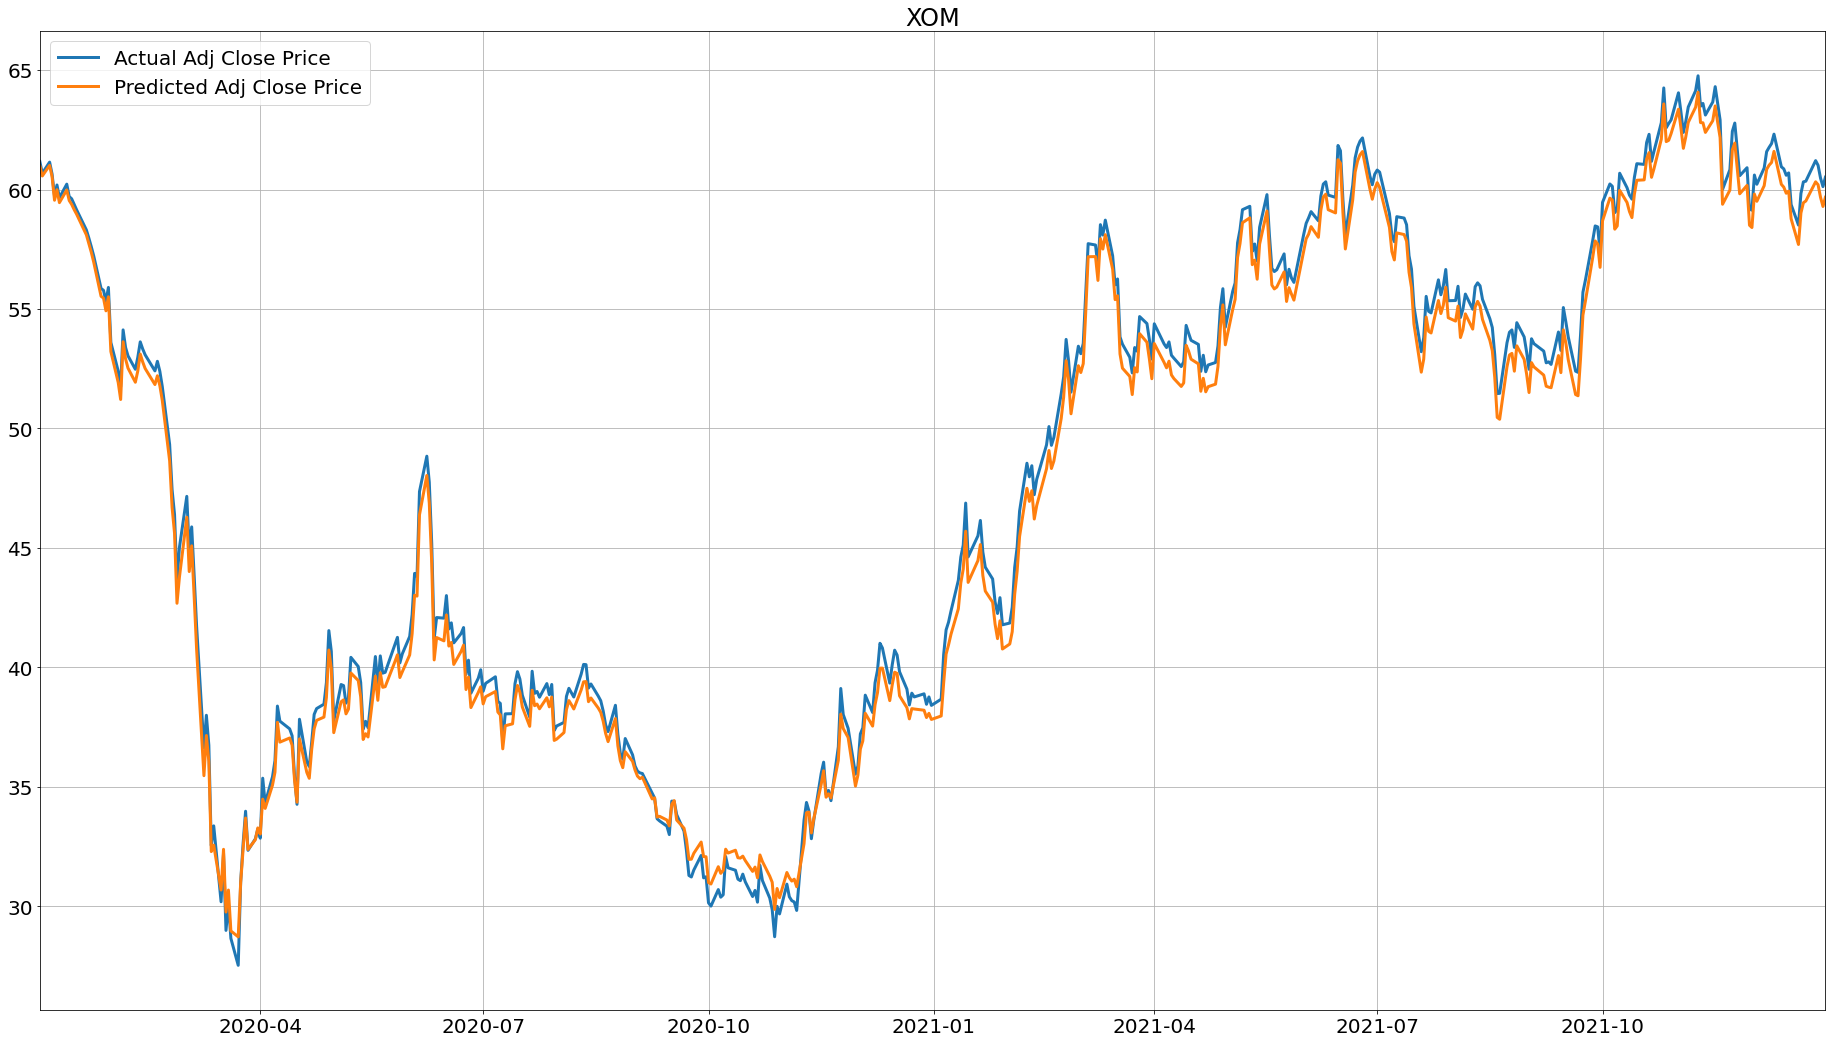

In [ ]:
# plotting actual and predicted Adj Close price of random ticker
rand_ticker = random.choice(tickers)
plt.plot(act_adj_close_test_df.index, act_adj_close_test_df[rand_ticker], label='Actual Adj Close Price')
plt.plot(pred_adj_close_df.index, pred_adj_close_df[rand_ticker], label='Predicted Adj Close Price')
plt.title(rand_ticker)
plt.xlim(act_adj_close_test_df.index[0], act_adj_close_test_df.index[-1])
plt.legend()
plt.show()

In [ ]:
# dataframe for daily portfolio returns
act_daily_port_ret_df = act_daily_ret_df.copy()
act_daily_port_ret_df.drop(columns=tickers, inplace=True)

In [ ]:
# risk free return
risk_free_ret = 0.015

In [ ]:
# function for adding different portfolios
def add_portfolio(portfolio, weights):
    act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_ret_df.dot(weights)
    if portfolio == 'Pred':
        # upper bound of security transaction tax: 0.0003
        act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_port_ret_df[f'{portfolio} Return'] - 0.0003
    act_daily_port_ret_df[f'{portfolio} Cum Prod Return'] = (1 + act_daily_port_ret_df[f'{portfolio} Return']).cumprod()

    exp_ret = act_daily_port_ret_df[f'{portfolio} Return'].mean()
    std = act_daily_port_ret_df[f'{portfolio} Return'].std()
    sharpe_ratio = (exp_ret - risk_free_ret) / std

    print(portfolio)
    print('Weights:')
    print(weights)
    print(f'Expected Return: {exp_ret:.6f}')
    print(f'Standard Dev   : {std:.6f}')
    print(f'Sharpe Ratio   : {sharpe_ratio:.6f}')

#### Equally weighted portfolio

In [ ]:
n_assets = len(tickers)
eq_weights = np.ones(n_assets) / n_assets

In [ ]:
add_portfolio('Eq', eq_weights)

Eq
Weights:
[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
Expected Return: 0.001297
Standard Dev   : 0.016466
Sharpe Ratio   : -0.832185


In [ ]:
sum(eq_weights)

0.9999999999999999

#### Market capitalization weighted portfolio

In [ ]:
cap_data = pdr.get_quote_yahoo(tickers)['marketCap']
cap_df = pd.DataFrame(cap_data)
cap_df['Weight'] = cap_df / cap_df.sum()
cap_weights = np.array(cap_df['Weight'])

In [ ]:
add_portfolio('Cap', cap_weights)

Cap
Weights:
[0.15230818 0.12241068 0.09818721 0.08633698 0.04918941 0.03946875
 0.03307276 0.03302888 0.02692827 0.02507876 0.02492222 0.02443444
 0.02142249 0.02077496 0.02073339 0.02024354 0.02016676 0.018817
 0.01577379 0.01506032 0.01480868 0.01443078 0.01389409 0.01310234
 0.01290708 0.01258096 0.01253955 0.01250762 0.01248011 0.01239   ]
Expected Return: 0.001634
Standard Dev   : 0.017458
Sharpe Ratio   : -0.765602


In [ ]:
sum(cap_weights)

1.0

#### LSTM predictions portfolio

In [ ]:
# function for getting inverse of expected return using predicted Adj Close price
# used to get optimum weights that maximize this expected return
def exp_ret_inv(weights):
    pred_daily_port_ret = pred_daily_ret_df.dot(weights)
    exp_ret = pred_daily_port_ret.mean()
    return 1 / exp_ret

In [ ]:
# expected return maximization using predicted Adj Close price
weights0 = eq_weights # initial weights
# bounds: weight should be between 0.0 and 1.0
bnds = tuple((0.0, 1.0) for i in range(n_assets))
# constraints: weights should add up to 1.0
cons = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1.0})

res = minimize(exp_ret_inv, weights0, method='SLSQP', bounds=bnds, constraints=cons)
pred_weights = res.x

In [ ]:
add_portfolio('Pred', pred_weights)

Pred
Weights:
[3.46512963e-15 0.00000000e+00 0.00000000e+00 2.27202905e-14
 1.00000000e+00 5.28027591e-14 5.87938465e-15 0.00000000e+00
 0.00000000e+00 5.56259282e-14 0.00000000e+00 9.65584547e-15
 1.45916365e-14 0.00000000e+00 0.00000000e+00 8.82925947e-15
 1.79191694e-14 8.00887863e-16 4.54089122e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.90390669e-14 3.15852470e-14
 2.52911333e-17 3.74662754e-14 0.00000000e+00 9.43049214e-15
 0.00000000e+00 0.00000000e+00]
Expected Return: 0.005781
Standard Dev   : 0.046837
Sharpe Ratio   : -0.196832


In [ ]:
sum(pred_weights)

1.0000000000003033

#### Plotting cummulative product returns

In [ ]:
act_daily_port_ret_df

,Eq Return,Eq Cum Prod Return,Cap Return,Cap Cum Prod Return,Pred Return,Pred Cum Prod Return
Date,,,,,,
2020-01-03,-0.007837,0.992163,-0.007683,0.992317,0.029333,1.029333
2020-01-06,0.003929,0.996061,0.007448,0.999708,0.018955,1.048844
2020-01-07,-0.002887,0.993186,-0.001669,0.998039,0.038501,1.089225
2020-01-08,0.006741,0.999881,0.009561,1.007581,0.048905,1.142493
2020-01-09,0.005829,1.005709,0.008449,1.016094,-0.022245,1.117078
...,...,...,...,...,...,...
2021-12-27,0.012828,1.802772,0.014036,2.131722,0.024948,10.948066
2021-12-28,-0.000789,1.801350,-0.002056,2.127339,-0.005300,10.890038
2021-12-29,0.000771,1.802739,-0.000130,2.127062,-0.002395,10.863960


In [ ]:
# Date of Investment: 02/01/2020

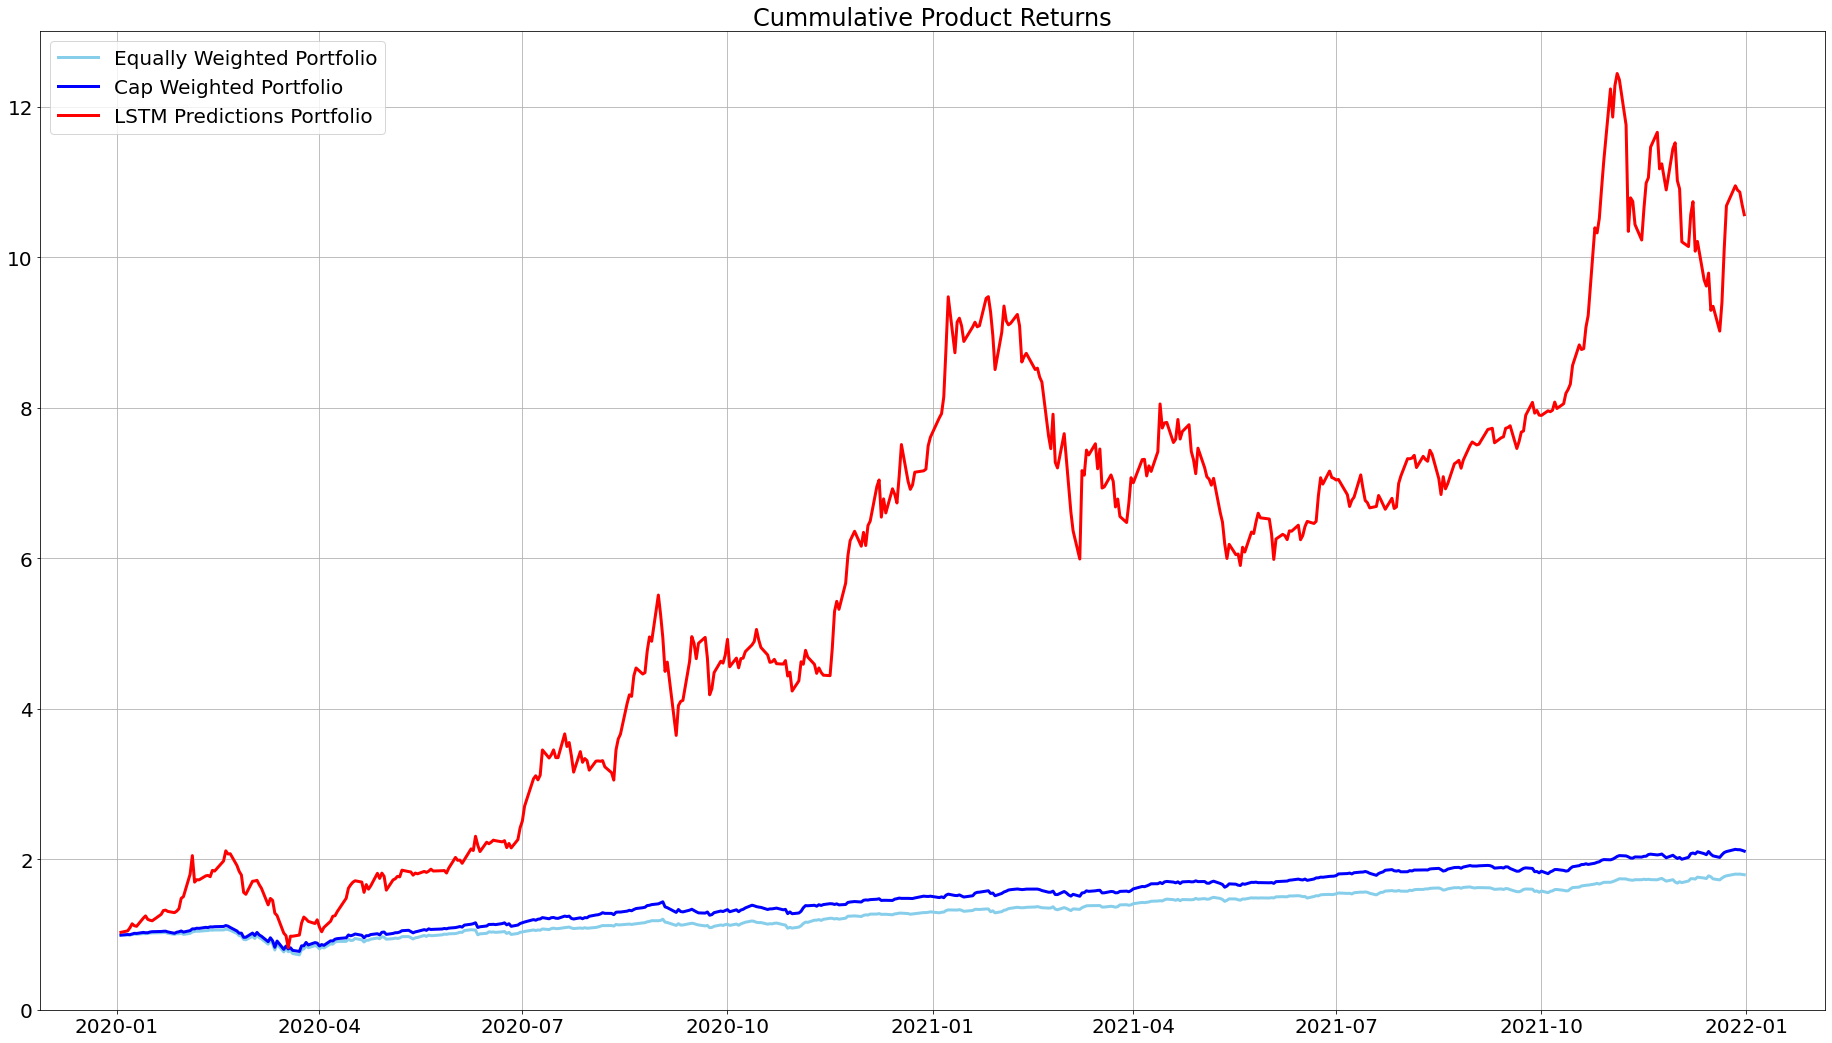

In [ ]:
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Eq Cum Prod Return'], 
         label='Equally Weighted Portfolio', color='skyblue')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Cap Cum Prod Return'], 
         label='Cap Weighted Portfolio', color='blue')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Pred Cum Prod Return'], 
         label='LSTM Predictions Portfolio', color='red')
plt.title('Cummulative Product Returns')
plt.ylim(0.0, 13.0)
plt.legend()
plt.show()